In [27]:
import os
import sys
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import LabelEncoder # we don't use this because the labels are already numbers (1,2,3)
#from sklearn.model_selection import cross_val_score
#from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics

from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

In [28]:
ROOT_PATH = "C:/Users/Oli/Desktop/Entrevistas/carebit insurtech/Carebit_exercise/"
sys.path.append(os.path.join(ROOT_PATH, 'src'))

## Case 1: Classification

### Loading data

In [3]:
EX_PATH = os.path.join(ROOT_PATH, "Data/seeds_dataset.txt")
df = pd.read_csv(EX_PATH, sep='\t', header = None)
df.columns = ['area', 'perimeter', 'compactness', 'kernel_length', 'kernel_width', 'asym_coef', 'kernel_groove_length', 'class']

In [4]:
df.head()

,area,perimeter,compactness,kernel_length,kernel_width,asym_coef,kernel_groove_length,class
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


### Separate X and Y

In [5]:
X, y = df.iloc[:, :-1], df.iloc[:, -1]

### Split X and y into training and testing datasets

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(168, 7)
(42, 7)
(168,)
(42,)


### Use the model of your choice to solve the multiclass problem: Fit the data and make the predictions.

First of all we want to know if the problem is balanced (more or less the same number of instances per class) or imbalanced.

In [7]:
counts = df[['class']].value_counts()
counts

class
3        70
2        70
1        70
dtype: int64

In this case we have a balanced dataset.

First of all we will fit a base random forest classifier with no tunning parameters

In [8]:
# define the reference model
model = RandomForestClassifier(n_estimators=1000, class_weight='balanced')

In [9]:
# fit the base model without hyperparameter tunning
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=1000)

In [10]:
# predict
yhat = model.predict(X_test)

In [11]:
yhat

array([2, 3, 1, 3, 1, 2, 3, 3, 3, 3, 2, 2, 1, 2, 3, 1, 1, 3, 2, 3, 1, 1,
       3, 2, 2, 1, 3, 1, 1, 3, 1, 3, 2, 2, 2, 3, 1, 1, 2, 2, 3, 2],
      dtype=int64)

We should tune the hyperparameters, otherwise we will be using the default parameters (except the number of trees)

In [12]:
# Using gridsearch to optimiza hyperparameters:


# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [13]:
# best parameters to apply to the classifier from fitting the random search:
rf_random.best_params_

{'n_estimators': 400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': False}

In [14]:
# predict
yhat = rf_random.predict(X_test)
yhat

array([2, 3, 1, 3, 1, 2, 3, 3, 3, 3, 2, 2, 1, 2, 3, 3, 1, 3, 2, 3, 1, 1,
       3, 2, 2, 1, 3, 1, 1, 3, 1, 3, 2, 2, 2, 3, 1, 1, 2, 2, 3, 2],
      dtype=int64)

### Evaluate the results using the metric of your choice.

Once the model is fitted with the training dataset, we want to know how good the classifier behaves with the holdout (test) dataset.

In this case, because of the data is balanced our metric will be the accuracy, so the percentage of good predictions our model does.

[[12  0  1]
 [ 0 14  0]
 [ 0  0 15]]


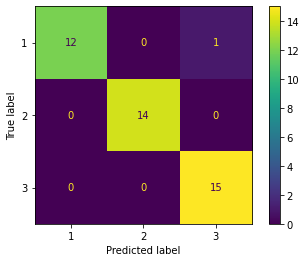

In [17]:
# Print the confusion matrix
print(metrics.confusion_matrix(y_test, yhat))
metrics.plot_confusion_matrix(rf_random, X_test, y_test)

In [18]:
# Print the precision and recall, among other metrics
print(metrics.classification_report(y_test, yhat, digits=3))

              precision    recall  f1-score   support

           1      1.000     0.923     0.960        13
           2      1.000     1.000     1.000        14
           3      0.938     1.000     0.968        15

    accuracy                          0.976        42
   macro avg      0.979     0.974     0.976        42
weighted avg      0.978     0.976     0.976        42



In [22]:
# overall accuracy
acc = rf_random.score(X_test,y_test)
acc

0.9761904761904762

The classifier has an accuracy of 97.6%, meaning that predict the correct class almost every time (almost 98  times out of 100).

In [ ]:
#To evaluate the model we will repeat 3 times 5-fold cross validation in order to get a robust metric (accuracy).

In [18]:
# evaluate a model
#def evaluate_model(X, y, model):
#    # define evaluation procedure
#    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
#    # evaluate model
#    scores = cross_val_score(rf_random, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
#    return scores

In [ ]:
## evaluate the model (takes so long when pass rf_random)
#scores = evaluate_model(X_test, y_test, rf_random)
## summarize performance
#print('Mean Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

How I will notice if there is overfitting? Overfitting in multiclass classification problem
Random Forest towardsdatascience
know exactly what all the functions do.

## Case 2: Regression

### Loading data

In [29]:
from sklearn.datasets import load_boston
boston = load_boston()
df_x = pd.DataFrame(boston.data, columns = boston.feature_names)
df_y = pd.DataFrame(boston.target, columns = ['target'])
df = df_x.join(df_y)
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


### Separate X and Y

In [30]:
X, y = df.iloc[:, :-1], df.iloc[:, -1]

### Split X and y into training and testing datasets

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=111)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(379, 13)
(127, 13)
(379,)
(127,)


### Use the model of your choice to solve the regression problem: Fit the data and make the predictions.

In [32]:
# prepare a range of alpha values to test
alphas = np.array([1,0.1,0.01,0.001,0.0001,0])
# create and fit a ridge regression model, testing each alpha
model = Ridge()
grid = GridSearchCV(estimator=model, param_grid=dict(alpha=alphas))
grid.fit(X_train, y_train)
print(grid)
# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_estimator_.alpha)

GridSearchCV(estimator=Ridge(),
             param_grid={'alpha': array([1.e+00, 1.e-01, 1.e-02, 1.e-03, 1.e-04, 0.e+00])})
0.6907416223120482
0.0


In [35]:
from scipy.stats import uniform as sp_rand
# prepare a uniform distribution to sample for the alpha parameter
param_grid = {'alpha': sp_rand()}
param_grid

TypeError: 'rv_frozen' object is not iterable

In [ ]:
from scipy.stats import uniform as sp_rand
# prepare a uniform distribution to sample for the alpha parameter
param_grid = {'alpha': sp_rand()}
# create and fit a ridge regression model, testing random alpha values
model = Ridge()
rsearch = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=100)
rsearch.fit(dataset.data, dataset.target)
print(rsearch)
# summarize the results of the random parameter search
print(rsearch.best_score_)
print(rsearch.best_estimator_.alpha)

In [ ]:
# Using gridsearch to optimiza hyperparameters:


# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

### Evaluate the results using the metric of your choice.

### Visualization plot

## Questions

#### Which models did you chose for each problem? Why?

#### Regarding the evaluation, which metrics are you using for the classification problem? Why are you using them and how do you interpret the results? And for the regression?

#### About the plot. How do you interpret the results? Which kind of relation is shown? Is it enough to take some conclusions or do we need to perform further analysis?